# Sistema Embarcado de Previsão Ambiental Multi-Horizonte com MLP

**Objetivo:** Desenvolver um modelo Edge ML (MLP) capaz de:
- **Classificar** a tendência atual de temperatura (Estável, Aquecendo, Resfriando)
- **Prever** temperatura futura em 3 horizontes: 5, 10 e 15 minutos

**Hardware:** BitDogLab (RP2040) com sensores AHT20 e BMP280

---


In [1]:
pip install pandas numpy tensorflow scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)


# 1. Carregar e Explorar os Dados

---


In [4]:
# Carregar o dataset completo
df_raw = pd.read_csv('data/temp.csv', parse_dates=['Timestamp'])
selected_columns = ['Timestamp', 'Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa']# Definir as colunas que serão utilizadas (Fusão de Sensores: AHT20 + BMP280)
df = df_raw[selected_columns].copy()# Definir as colunas que serão utilizadas (Fusão de Sensores: AHT20 + BMP280) para nossa rede


# Exibir informações do dataset
print(f"Total de amostras: {len(df)}")
print(f"Período: {df['Timestamp'].min()} até {df['Timestamp'].max()}")
print(f"\nColunas selecionadas:\n{df.columns.tolist()}")
print(f"\nPrimeiras linhas:")
print(df.head())

Total de amostras: 82430
Período: 2025-08-31 22:31:02 até 2025-09-30 16:52:09

Colunas selecionadas:
['Timestamp', 'Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa']

Primeiras linhas:
            Timestamp  Temp_AHT20_C  Umid_AHT20_pct  Temp_BMP280_C  \
0 2025-08-31 22:31:02         19.90           73.37          21.28   
1 2025-08-31 22:31:33         19.97           75.57          21.48   
2 2025-08-31 22:32:05         19.75           74.31          21.25   
3 2025-08-31 22:32:36         19.55           74.77          21.07   
4 2025-08-31 22:33:07         19.60           75.09          21.12   

   Press_BMP280_hPa  
0            921.24  
1            921.12  
2            921.20  
3            921.15  
4            921.25  


In [5]:
print(f"\nEstatísticas descritivas:")
print(df[['Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa']].describe())


Estatísticas descritivas:
       Temp_AHT20_C  Umid_AHT20_pct  Temp_BMP280_C  Press_BMP280_hPa
count  82430.000000    82430.000000   82430.000000      82430.000000
mean      20.328970       65.946394      21.803339        918.146819
std        3.452443       13.343084       3.350503          2.147400
min       13.440000       35.440000      15.120000        912.100000
25%       17.610000       54.520000      19.160000        916.600000
50%       19.750000       68.950000      21.240000        918.300000
75%       22.990000       77.310000      24.400000        919.790000
max       29.390000       92.130000      30.590000        922.990000


In [6]:
print(df.isnull().sum())#Verificar se existem valores nulos
# Remover linhas com valores nulos (se existirem)
df_clean = df.dropna()
print(f"\nDados após limpeza: {len(df_clean)} amostras ({len(df) - len(df_clean)} removidas)")

Timestamp           0
Temp_AHT20_C        0
Umid_AHT20_pct      0
Temp_BMP280_C       0
Press_BMP280_hPa    0
dtype: int64

Dados após limpeza: 82430 amostras (0 removidas)


- Vemos que não teve dados nulos.

# 2. Análise Exploratória de Dados (EDA)

Visualizar e entender o comportamento dos sensores antes de treinar o modelo

---


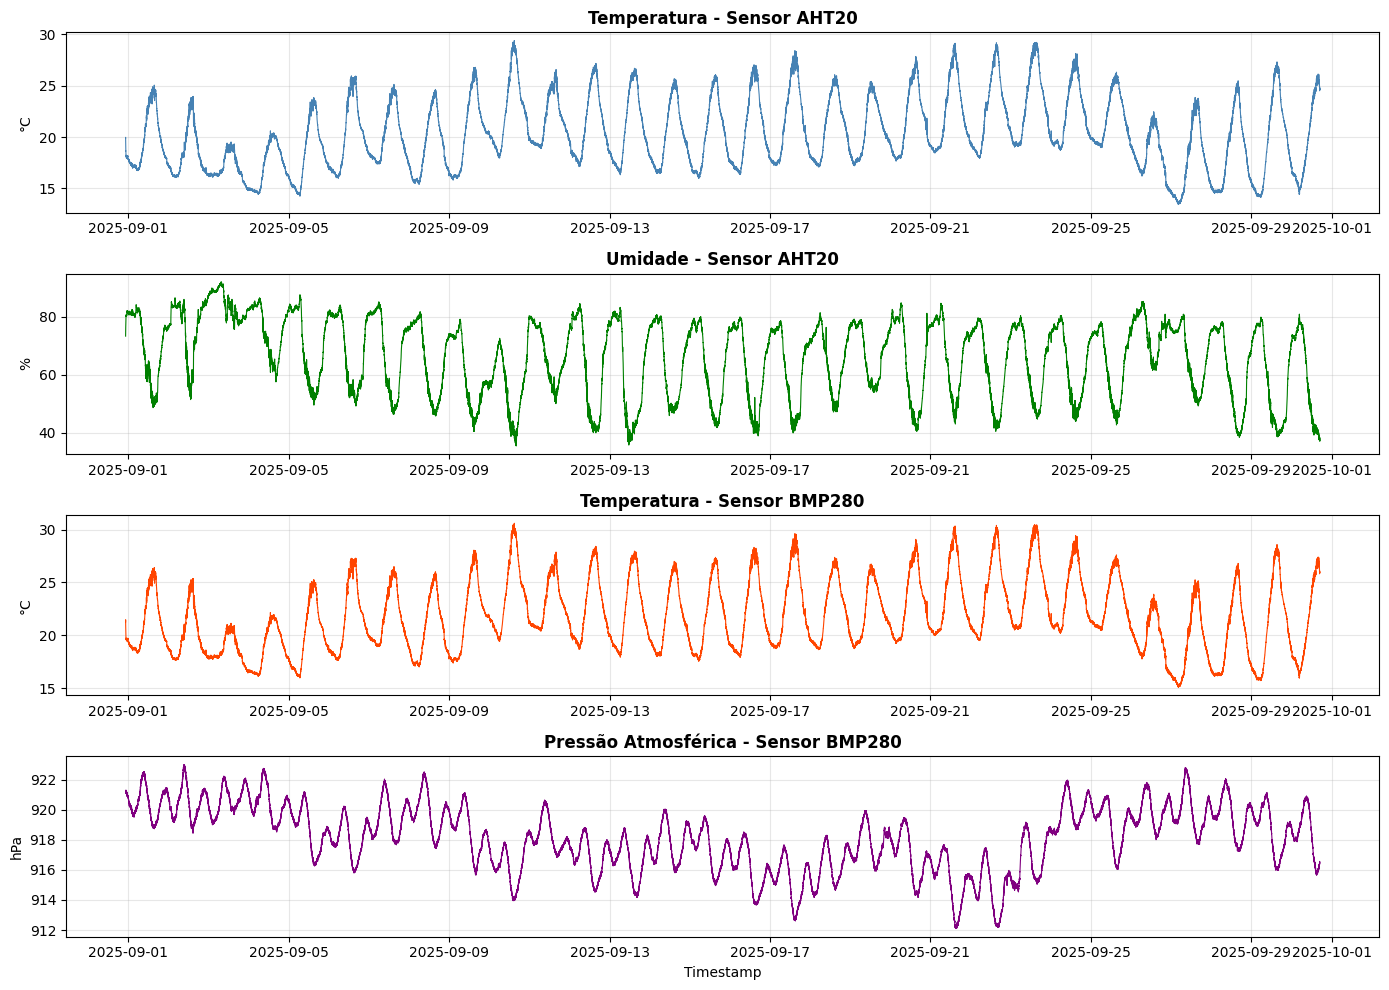

In [7]:
# Plotar séries temporais de todas as features
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Temperatura AHT20
axes[0].plot(df_clean['Timestamp'], df_clean['Temp_AHT20_C'], color='steelblue', linewidth=0.8)
axes[0].set_title('Temperatura - Sensor AHT20', fontsize=12, fontweight='bold')
axes[0].set_ylabel('°C')
axes[0].grid(True, alpha=0.3)

# Umidade AHT20
axes[1].plot(df_clean['Timestamp'], df_clean['Umid_AHT20_pct'], color='green', linewidth=0.8)
axes[1].set_title('Umidade - Sensor AHT20', fontsize=12, fontweight='bold')
axes[1].set_ylabel('%')
axes[1].grid(True, alpha=0.3)

# Temperatura BMP280
axes[2].plot(df_clean['Timestamp'], df_clean['Temp_BMP280_C'], color='orangered', linewidth=0.8)
axes[2].set_title('Temperatura - Sensor BMP280', fontsize=12, fontweight='bold')
axes[2].set_ylabel('°C')
axes[2].grid(True, alpha=0.3)

# Pressão BMP280
axes[3].plot(df_clean['Timestamp'], df_clean['Press_BMP280_hPa'], color='purple', linewidth=0.8)
axes[3].set_title('Pressão Atmosférica - Sensor BMP280', fontsize=12, fontweight='bold')
axes[3].set_ylabel('hPa')
axes[3].set_xlabel('Timestamp')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


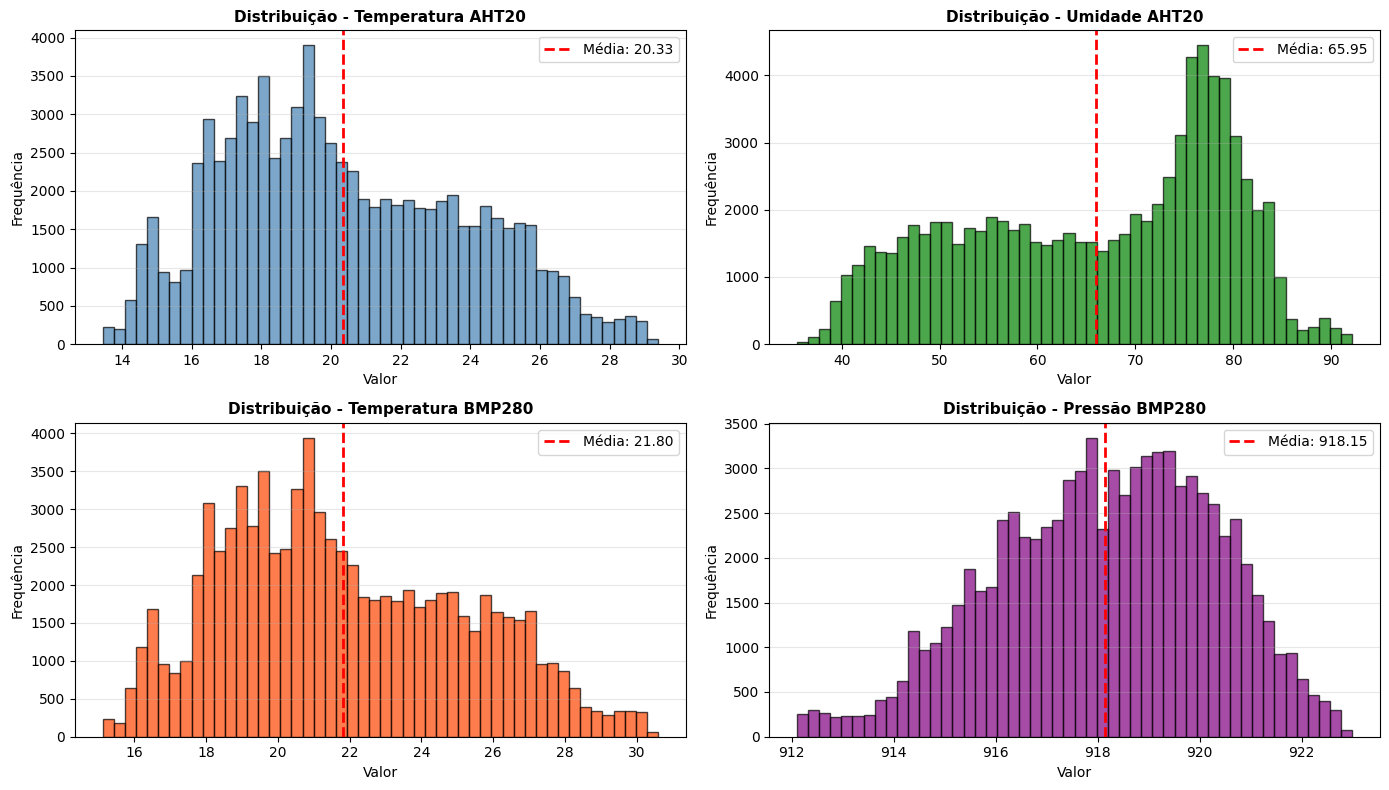

In [9]:
# Plotar histogramas de todas as features
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Lista de features para plotar
features = ['Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa']
colors = ['steelblue', 'green', 'orangered', 'purple']
titles = ['Temperatura AHT20', 'Umidade AHT20', 'Temperatura BMP280', 'Pressão BMP280']

# Plotar cada histograma
for idx, (feature, color, title) in enumerate(zip(features, colors, titles)):
    row = idx // 2
    col = idx % 2
    
    # Histograma com KDE (Kernel Density Estimation)
    axes[row, col].hist(df_clean[feature], bins=50, color=color, alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'Distribuição - {title}', fontsize=11, fontweight='bold')
    axes[row, col].set_xlabel('Valor')
    axes[row, col].set_ylabel('Frequência')
    axes[row, col].grid(True, alpha=0.3, axis='y')
    
    # Adicionar linha vertical da média
    mean_val = df_clean[feature].mean()
    axes[row, col].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_val:.2f}')
    axes[row, col].legend()

plt.tight_layout()
plt.show()


Os gráficos revelam distribuições multimodais e assimétricas, indicando que os sensores capturaram diferentes estados ambientais ao longo do tempo, como ciclos de dia e noite. Enquanto as temperaturas (AHT20 e BMP280) apresentam picos variados entre 18°C e 22°C com um leve alongamento à direita, a umidade exibe uma concentração bimodal acentuada, sugerindo períodos de alta saturação (próximos a 80%). Já a pressão atmosférica aproxima-se de uma distribuição mais regular, porém com flutuações que sugerem instabilidade climática ou mudanças na massa de ar durante a coleta.

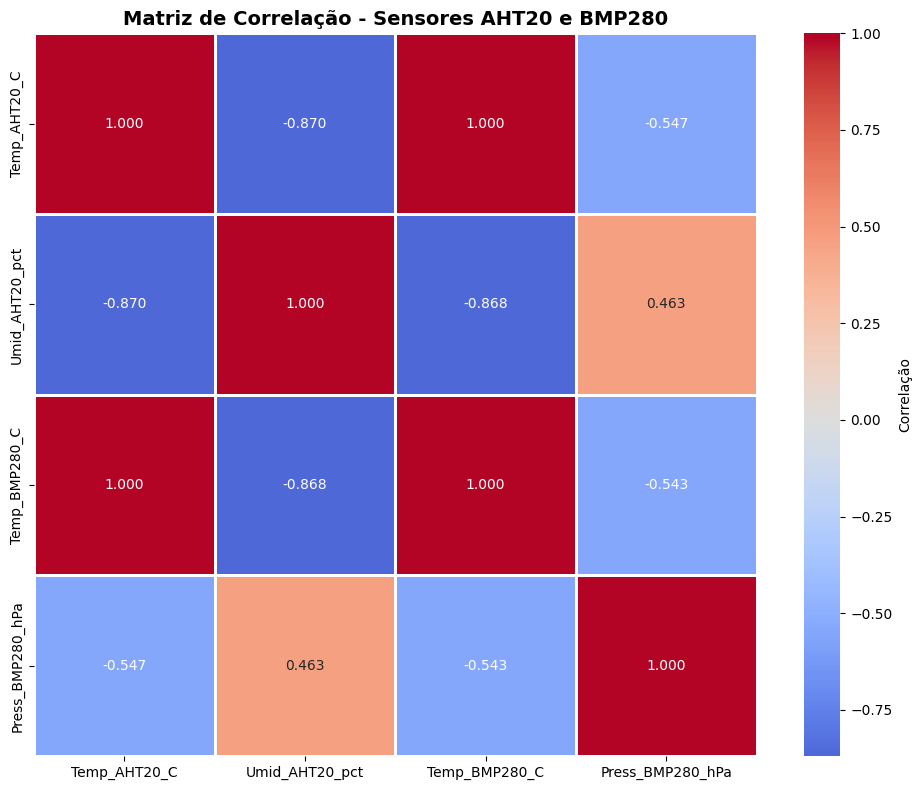

In [14]:
correlation_matrix = df_clean[features].corr()# Calcular matriz de correlação entre as variaveis

#Plotar heatmap de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,          
    fmt='.3f',#3 casas decimais
    cmap='coolwarm', #Esquema de cores
    center=0, #Centralizar em 0
    square=True, #Células quadradas
    linewidths=1,#Linhas entre células
    cbar_kws={'label': 'Correlação'}
)
plt.title('Matriz de Correlação - Sensores AHT20 e BMP280', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

A matriz exibe uma correlação perfeita (1,000) entre os sensores de temperatura, validando a consistência dos dados coletados para o hardware. Nota-se uma forte relação negativa (-0,870) entre temperatura e umidade, confirmando o comportamento físico esperado de queda na umidade sob maior calor. Já a pressão mostra uma dependência moderada e inversa com a temperatura, completando um cenário de alta previsibilidade para modelos climáticos.

# 3. Criar Janelas Deslizantes (Sliding Windows)

Transformamos a série temporal em problema supervisionado:
- **Entrada:** Últimos 10 minutos de leituras (10 timesteps × 4 features = 40 valores)
- **Saída 1 (Classificação):** Tendência atual (Estável, Aquecendo, Resfriando)
- **Saída 2 (Regressão):** Temperatura em T+1, T+2, T+3 (5, 10, 15 min à frente)

---


In [15]:
def create_sliding_windows(df, window_size=10, horizon_steps=[1, 2, 3]):
    """
    Cria janelas deslizantes para treinamento do modelo.
    
    Parâmetros:
    - df: DataFrame com os dados dos sensores
    - window_size: Tamanho da janela histórica (padrão: 10 timesteps)
    - horizon_steps: Lista com os horizontes de previsão (padrão: [1, 2, 3])
    
    Retorna:
    - X: Janelas de entrada (features)
    - y_class: Labels de classificação (tendência)
    - y_reg: Valores de regressão (temperaturas futuras)
    """
    features_columns = ['Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa'] #features
    target_column = 'Temp_AHT20_C'  # Usar temperatura do AHT20 como alvo
    
    X, y_class, y_reg = [], [], []
    
    # Iterar pelos dados criando as janelas
    for i in range(len(df) - window_size - max(horizon_steps)):
        window = df.iloc[i:i+window_size][features_columns].values # Extrair janela de entrada (últimos 10 timesteps)
        X.append(window.flatten())  # Achatar de (10, 4) para (40,)        
        current_temp = df.iloc[i+window_size-1][target_column] # Temperatura atual e próxima para classificação
        next_temp = df.iloc[i+window_size][target_column]
        future_temps = [df.iloc[i+window_size+h][target_column] for h in horizon_steps]#Temperaturas futuras para regressão (T+1, T+2, T+3)
        # Classificar tendência baseada na variação de temperatura
        temp_change = next_temp - current_temp
        if temp_change > 0.1:
            y_class.append(1)  # Aquecendo
        elif temp_change < -0.1:
            y_class.append(2)  # Resfriando
        else:
            y_class.append(0)  # Estável
        
        # Adicionar valores de regressão
        y_reg.append(future_temps)
    
    return np.array(X), np.array(y_class), np.array(y_reg)

# Configurar parâmetros da janela
WINDOW_SIZE = 10  # 10 minutos de histórico
HORIZON_STEPS = [1, 2, 3]  # Prever 5, 10 e 15 minutos à frente
X, y_class, y_reg = create_sliding_windows(df_clean, WINDOW_SIZE, HORIZON_STEPS)#Criar as janelas deslizantes

# Exibir shape dos arrays criados
print(f"\nShape dos dados:")
print(f"X (janelas de entrada): {X.shape}")
print(f"y_class (classificação - tendência): {y_class.shape}")
print(f"y_reg (regressão - previsões): {y_reg.shape}")



Shape dos dados:
X (janelas de entrada): (82417, 40)
y_class (classificação - tendência): (82417,)
y_reg (regressão - previsões): (82417, 3)
